# Deep Deterministic Policy Gradient (DDPG)

## Introduction

Deep Deterministic Policy Gradient(DDPG)는 continuous actions 학습을 위한 model-free off-policy algorithm이다.

DPG(Deteministic Policy Gradient)와 DQN(Deep Q-Network)의 아이디어를 합친 것.

DPG를 기반으로 Replay buffer와 target Q network 사용하여 continuous action spaces에서 작동하도록 한다.

<img src='../img/RL04.png' width='600'>

### On-policy VS Off-policy

<img src='../img/ddpg02.png' width='600'>

- On-policy

On policy는 behavior policy와 target policy가 같다. 

즉 현재 행동하는 policy를 그대로 update할 목적으로 환경을 탐색. 

현재 policy를 통해 얻은 trajectories를 가지고 policy를 update를 하기 때문에 얻어지는 state distribution 자체가 현재 policy에 의존적. 

그렇기 때문에, data dependent. 

이는 local optimal에 수렴할 수 있는 가능성. 

또한 한번 policy를 update한 후, 그 이전의 trajectories는 현재의 policy와 다르기 때문에 더이상 쓸 수 없다. 

하지만 주로 update할 action selection이 stochastic하기 때문에, exploration strategy에서 off policy보다 편할 수 있다.

$$Q(s,a) \leftarrow Q(s,a)+\alpha\cdot(r_s+\gamma Q(s',a')-Q(s,a))$$

- Off-policy

Off policy는 behavior policy와 target policy가 다르다. 

현재 행동하는 policies와 update할 policy가 달라도 된다는 뜻. 

이는 target policy와 behavior policy에 의한 distribution차이를 Importance Sampling(IS)을 이용해 해결하거나 target policy의 action selection을 주로 max의 연산으로 deterministic하게 취함으로써 해결. 

approximated action value function $\hat{Q}$가 있을때, 한 state $s_t$에서의 $\hat{Q}(s,a)$의 더 정확한 값은 $r(s,a)+max_{a'}\hat{Q}(s',a')$이기 때문에 업데이트 할 수 있다. 

이는 target policy의 action을 제한시켰기 때문에, local optimal에 빠지지 않기 위해 exploration strategy가 필요. 

그중 가장 간단하게는 epsilon-greedy를 사용하지만, 이는 비효율적이기 때문에, 또 다른 많은 exploration 전략이 존재.

$$Q(s,a) \leftarrow Q(s,a)+\alpha\cdot(r_s+\gamma \underset{a'}{max}Q(s',a')-Q(s,a))$$


### DQN

DQN의 가장 큰 contribution은 두 가지 아이디어로 Q-learning 알고리즘을 개선해서 neural network predictor 적용에 성공한 것. 

1. experience replay
    - 인접한 학습 데이터 사이의 correlation으로 인한 비효율성을 극복하기 위한 기법 
    - 게임을 하는 agent의 경험 데이터$(s,a,r,s')$를 replay memory라는 이름의 buffer pool에 매 순간 저장
    - update 할 때는 replay memory에서 random하게 minibatch 크기의 sample을 뽑아 계산하는 것


2. target network
    - DQN과 똑같은 neural network을 하나 더 만들어, 그 weight 값이 가끔씩만 update 되도록 한 것
    - $Q(s,a)$를 학습하는 순간, target 값도 따라 변하면서 학습 성능이 떨어지는 문제를 개선하기 위해서
    - Target network의 weight 값들은 주기적으로 DQN의 값을 복사. 
    - Q-learning의 update에서 아래 식과 같은 loss function을 사용하는데, 먼저 나오는 Q는 target network에서 계산한 것이고 뒤의 Q는 원래의 DQN에서 계산한 것
    
$$L_i(\theta_i)=E_{(s,a,r,s')~U(D)}[(r+\gamma\underset{a'}{\mathrm{max}}Q(s',a';\theta^{-}_i)-Q(s,a;\theta_i))^2]$$

### Actor Critic

Actor-Critic 알고리즘은 Actor 네트워크와 Critic 네트워크라는 두 개의 네트워크를 사용

Actor는 상태가 주어졌을 때 행동을 결정하고, Critic은 상태의 가치를 평가



## DDPG

### DQN의 한계점

1. discrete, low-dimentional action spaces만 다룰 수 있다.
2. 모든 단계에서 반복적인 최적화 프로세스를 필요로 하는 action-value function을 maximize하는 행동을 찾는 것에 의존하기 때문에 continuous domain에 직접 적용할 수 없다.

### Contribution

1. replay buffer

- 강화학습을 neural networks를 사용하여 학습할 때 대부분의 optimization algorithm이 sample이 독립적이고 동일하게 분포되어 있다고 가정하는 문제점
- 이를 해결하기 위해 replay buffer 사용
- $(s_t,a_t,r_t,s_{t+1})$
- 각 timestep에서 actor와 critic은 buffer에서 균일하게 mini-batch를 샘플링하여 업데이트하고 uncorrelated transitions를 학습할 수 있는 이점

2. soft target update

- neural network를 사용하여 Q-learning을 직접 구현하는 것은 불안정
- 업데이트중인 network $Q(s,a|\theta^Q)$도 target value를 계산하는데 사용되기 때문에 업데이트가 발산하는 경향
- DQN에서 target network를 사용하는 것과 유사하지만 가중치를 직접 복사하는 대신 Actor, Critic에 "soft" target update
- target value 생성을 위해 actor($Q'(s,a|\theta^{Q'}$)와 critic($\mu'(s|\theta^{\mu'}$) network 복사
- 그 다음 학습된 network를 천천히 추적하도록 target network의 가중치 업데이트
$$\theta' \leftarrow \tau\theta+(1-\tau)\theta' \;\;\; \mathrm{with} \;\;\tau << 1$$
- target value가 천천히 변경되도록 제한하여 학습의 안정성을 향상(학습 속도는 느려질 수 있음)

3. batch normalization

- 서로 다른 구성요소는 서로 다른 물리적 단위를 가질 수 있고 범위가 environment 마다 다르다.
- 이는 network가 효과적으로 학습하기 어렵고 일반화되는 hyper parameter를 찾기 어려울 수 있다.
- 이를 해결하기 위해 batch normalization 사용
- 단위 평균과 분산을 갖도록 mini-batch의 sample에 대한 각 차원을 정규화
- 또한 테스트 중 정규화에 사용할 mean, variance의 running average를 유지

4. noise process

- noise process $N$에서 샘플링된 noise를 actor policy에 추가하여 탐색 정책 $\mu'$ 구성

$$\mu'(s_t)=\mu(s_t|\theta_t^{\mu})+N$$

- Ornstein-Uhlenbeck process 이용

## Problem

Inverted Pendulum control problem을 play

Action : swing left or swing right.

Actions가 discrete하지 않고 continuous

In [1]:
import gym
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
problem = "Pendulum-v0"
env = gym.make(problem)

num_states = env.observation_space.shape[0]
print("Size of State Space ->  {}".format(num_states))
num_actions = env.action_space.shape[0]
print("Size of Action Space ->  {}".format(num_actions))

upper_bound = env.action_space.high[0]
lower_bound = env.action_space.low[0]

print("Max Value of Action ->  {}".format(upper_bound))
print("Min Value of Action ->  {}".format(lower_bound))

Size of State Space ->  3
Size of Action Space ->  1
Max Value of Action ->  2.0
Min Value of Action ->  -2.0


### Ornstein-Uhlenbeck process

$$dx_t=\theta (\mu-x_t)+\sigma dW_t$$

- OU Process는 평균으로 회귀하는 random process
- θ는 얼마나 빨리 평균으로 회귀할 지를 나타내는 파라미터이며 μ는 평균
- σ는 process의 변동성을 의미하며 Wt는 Wiener process(변수의 변화가 평균이 0이고 분산이 1인 특성을 가지는 확률과정)를 의미
- 따라서 이전의 noise들과 temporally correlated
- 위와 같은 temporally correlated noise process를 사용하는 이유는 physical control과 같은 관성이 있는 환경에서 학습 시킬 때 보다 효과적이기 때문

In [4]:
class OUActionNoise:
    def __init__(self, mean, std_deviation, theta=0.15, dt=1e-2, x_initial=None):
        self.theta = theta
        self.mean = mean
        self.std_dev = std_deviation
        self.dt = dt
        self.x_initial = x_initial
        self.reset()

    def __call__(self):
        # Formula taken from https://www.wikipedia.org/wiki/Ornstein-Uhlenbeck_process.
        x = (
            self.x_prev
            + self.theta * (self.mean - self.x_prev) * self.dt
            + self.std_dev * np.sqrt(self.dt) * np.random.normal(size=self.mean.shape)
        )
        # Store x into x_prev
        # Makes next noise dependent on current one
        self.x_prev = x
        return x

    def reset(self):
        if self.x_initial is not None:
            self.x_prev = self.x_initial
        else:
            self.x_prev = np.zeros_like(self.mean)

<img src='../img/ddpg01.png'>

In [5]:
class Buffer:
    def __init__(self, buffer_capacity=100000, batch_size=64):
        # Number of "experiences" to store at max
        self.buffer_capacity = buffer_capacity
        # Num of tuples to train on.
        self.batch_size = batch_size

        # Its tells us num of times record() was called.
        self.buffer_counter = 0

        # Instead of list of tuples as the exp.replay concept go
        # We use different np.arrays for each tuple element
        self.state_buffer = np.zeros((self.buffer_capacity, num_states))
        self.action_buffer = np.zeros((self.buffer_capacity, num_actions))
        self.reward_buffer = np.zeros((self.buffer_capacity, 1))
        self.next_state_buffer = np.zeros((self.buffer_capacity, num_states))

    # Takes (s,a,r,s') obervation tuple as input
    def record(self, obs_tuple):
        # Set index to zero if buffer_capacity is exceeded,
        # replacing old records
        index = self.buffer_counter % self.buffer_capacity

        self.state_buffer[index] = obs_tuple[0]
        self.action_buffer[index] = obs_tuple[1]
        self.reward_buffer[index] = obs_tuple[2]
        self.next_state_buffer[index] = obs_tuple[3]

        self.buffer_counter += 1

    def update(
        self, state_batch, action_batch, reward_batch, next_state_batch,
    ):
        critic_optimizer.zero_grad(set_to_none=True)
        target_actions = target_actor(next_state_batch)
        y = reward_batch + gamma * target_critic(
            next_state_batch, target_actions
        )
        critic_value = critic_model(state_batch, action_batch)
        critic_loss = torch.mean(torch.square(y - critic_value))
        critic_loss.backward()
        critic_optimizer.step()
        
        actor_optimizer.zero_grad(set_to_none=True)
        actions = actor_model(state_batch)
        critic_value = critic_model(state_batch, actions)
        actor_loss = -torch.mean(critic_value)
        actor_loss.backward()
        actor_optimizer.step()
        
    # We compute the loss and update parameters
    def learn(self):
        # Get sampling range
        record_range = min(self.buffer_counter, self.buffer_capacity)
        # Randomly sample indices
        batch_indices = np.random.choice(record_range, self.batch_size)

        # Convert to tensors
        state_batch = torch.from_numpy(self.state_buffer[batch_indices]).float().to(device)
        action_batch = torch.from_numpy(self.action_buffer[batch_indices]).float().to(device)
        reward_batch = torch.from_numpy(self.reward_buffer[batch_indices])
        reward_batch = reward_batch.type(torch.FloatTensor).to(device)
        next_state_batch = torch.from_numpy(self.next_state_buffer[batch_indices]).float().to(device)

        self.update(state_batch, action_batch, reward_batch, next_state_batch)


# This update target parameters slowly
# Based on rate `tau`, which is much less than one.
def update_target(target_weights, weights, tau):
    for (a, b) in zip(target_weights, weights):
        a.data.copy_(b * tau + a * (1 - tau))

$$L_i(\theta_i)=E_{(s,a,r,s')~U(D)}[(r+\gamma\underset{a'}{\mathrm{max}}Q(s',a';\theta^{-}_i)-Q(s,a;\theta_i))^2]$$

### actor, critic

<img src='../img/ddpg03.png' width='500'> 

In [6]:
class get_actor(nn.Module):
    def __init__(self, num_states, upper_bound):
        super(get_actor, self).__init__()
        
        self.upper_bound = torch.as_tensor(upper_bound).to(device)

        Linear1 = nn.Linear(num_states, 256)
        Linear2 = nn.Linear(256, 256)
        Linear3 = nn.Linear(256, 1)
        
        nn.init.uniform_(Linear3.weight, a=-0.003, b=0.003)
        
        self.actor_layer = nn.Sequential(
            Linear1,
            nn.ReLU(),
            Linear2,
            nn.ReLU(),
            Linear3,
            nn.Tanh()
        )
        
    def forward(self, inputs):
        output = self.actor_layer(inputs)
        return output * self.upper_bound

class get_critic(nn.Module):
    def __init__(self, num_states, num_actions):
        super(get_critic, self).__init__()
                
        self.state_layer = nn.Sequential(
            nn.Linear(num_states, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
        )
        
        self.action_layer = nn.Sequential(
            nn.Linear(num_actions, 32),
            nn.ReLU()
        )
        
        self.out_layer = nn.Sequential(
            nn.Linear(64, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 1)
        )
        
    def forward(self, state_input, action_input):
        state_out = self.state_layer(state_input)
        action_out = self.action_layer(action_input)
        concat = torch.cat((state_out, action_out), 1)
        output = self.out_layer(concat)
        return output

In [7]:
def policy(state, noise_object, upper_bound, lower_bound):
    sampled_actions = torch.squeeze(actor_model(state))
    noise = noise_object()
    # Adding noise to action
    sampled_actions = sampled_actions.detach().cpu().numpy() + noise

    # We make sure action is within bounds
    legal_action = np.clip(sampled_actions, lower_bound, upper_bound)

    return [np.squeeze(legal_action)]

In [29]:
std_dev = 0.2
ou_noise = OUActionNoise(mean=np.zeros(1), std_deviation=float(std_dev) * np.ones(1))

actor_model = get_actor(num_states, upper_bound).to(device)
critic_model = get_critic(num_states, num_actions).to(device)

target_actor = get_actor(num_states, upper_bound).to(device)
target_critic = get_critic(num_states, num_actions).to(device)

# Making the weights equal initially
target_actor.load_state_dict(actor_model.state_dict())
target_critic.load_state_dict(critic_model.state_dict())

# Learning rate for actor-critic models
critic_lr = 0.002
actor_lr = 0.001

critic_optimizer = optim.Adam(critic_model.parameters(), lr=critic_lr)
actor_optimizer = optim.Adam(actor_model.parameters(), lr=actor_lr)

total_episodes = 100
# Discount factor for future rewards
gamma = 0.99
# Used to update target networks
tau = 0.005

buffer = Buffer(50000, 64)

Episode * 0 * Avg Reward is ==> -1828.1104350351843
Episode * 1 * Avg Reward is ==> -1359.005424850464
Episode * 2 * Avg Reward is ==> -1201.0969984522255
Episode * 3 * Avg Reward is ==> -1181.0072726495396
Episode * 4 * Avg Reward is ==> -1158.3771528731752
Episode * 5 * Avg Reward is ==> -1174.179801978392
Episode * 6 * Avg Reward is ==> -1191.8360957868788
Episode * 7 * Avg Reward is ==> -1259.95065625434
Episode * 8 * Avg Reward is ==> -1304.9775454291876
Episode * 9 * Avg Reward is ==> -1323.647065888557
Episode * 10 * Avg Reward is ==> -1296.357717669625
Episode * 11 * Avg Reward is ==> -1312.4955347474634
Episode * 12 * Avg Reward is ==> -1307.1410655381237
Episode * 13 * Avg Reward is ==> -1295.8500341730828
Episode * 14 * Avg Reward is ==> -1287.642883260109
Episode * 15 * Avg Reward is ==> -1270.251537210312
Episode * 16 * Avg Reward is ==> -1259.8241618881261
Episode * 17 * Avg Reward is ==> -1245.186677682304
Episode * 18 * Avg Reward is ==> -1231.8900052840856
Episode * 19

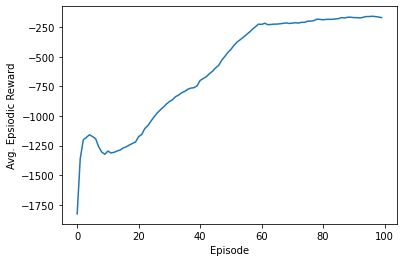

In [30]:
# To store reward history of each episode
ep_reward_list = []
# To store average reward history of last few episodes
avg_reward_list = []

for ep in range(total_episodes):

    prev_state = env.reset()
    episodic_reward = 0

    while True:
        torch_prev_state = torch.unsqueeze(torch.Tensor(prev_state), 0).to(device)

        action = policy(torch_prev_state, ou_noise, upper_bound, lower_bound)
        # Recieve state and reward from environment.
        state, reward, done, info = env.step(action)

        buffer.record((prev_state, action, reward, state))
        episodic_reward += reward

        buffer.learn()
        update_target(target_actor.parameters(), actor_model.parameters(), tau)
        update_target(target_critic.parameters(), critic_model.parameters(), tau)

        # End this episode when `done` is True
        if done:
            break

        prev_state = state

    ep_reward_list.append(episodic_reward)

    # Mean of last 40 episodes
    avg_reward = np.mean(ep_reward_list[-40:])
    print("Episode * {} * Avg Reward is ==> {}".format(ep, avg_reward))
    avg_reward_list.append(avg_reward)

# Plotting graph
# Episodes versus Avg. Rewards
plt.plot(avg_reward_list)
plt.xlabel("Episode")
plt.ylabel("Avg. Epsiodic Reward")
plt.show()

In [31]:
# Save the weights
torch.save(actor_model.state_dict(), "pendulum_actor.pt")
torch.save(critic_model.state_dict(), "pendulum_critic.pt")

torch.save(target_actor.state_dict(), "pendulum_target_actor.pt")
torch.save(target_critic.state_dict(), "pendulum_target_critic.pt")

In [32]:
# Render an episode and save as a GIF file

from IPython import display as ipythondisplay
from PIL import Image
from pyvirtualdisplay import Display


display = Display(visible=0, size=(400, 300))
display.start()


def render_episode(env): 
    screen = env.render(mode='rgb_array')
    im = Image.fromarray(screen)

    images = [im]
  
    state = env.reset()
    while True:

        torch_prev_state = torch.unsqueeze(torch.Tensor(prev_state), 0).to(device)

        action = actor_model(torch_prev_state).detach().cpu()
        state, reward, done, info = env.step(action)

        screen = env.render(mode='rgb_array')
        images.append(Image.fromarray(screen))
  
        if done:
            break
  
    return images


# Save GIF image
images = render_episode(env)
image_file = 'Pendulum-v0.gif'
# loop=0: loop forever, duration=1: play each frame for 1ms
images[0].save(
    image_file, save_all=True, append_images=images[1:], loop=0, duration=1)

<img src='../img/ddpg04.gif' width='300'>

<img src='../img/ddpg05.gif' width='300'>

---